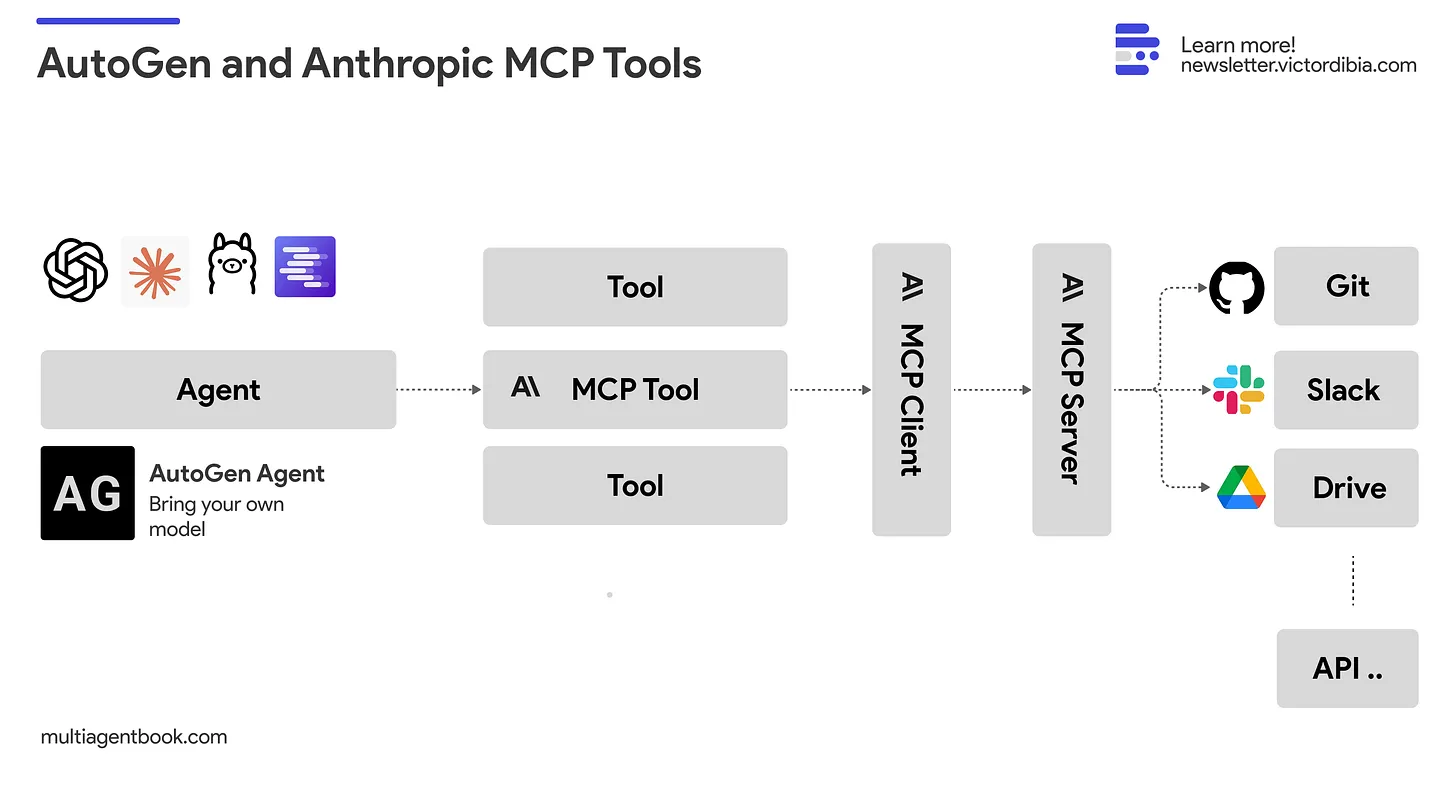

Integrating MCP tools with AutoGen is straightforward. 
- The key component is the `mcp_server_tools` function, which bridges your agent with MCP servers. 
- Under the hood, `mcp_server_tools` implements an `McpToolAdapter` which inherits from the AutoGen `BaseTool` class. 
- This adapter leverages AutoGen's existing infrastructure for creating annotations and tool schemas, making the MCP tools seamlessly available to your agent.

In the example below, we will show how to use the MCP fetch server provided by the Anthropic team - A Model Context Protocol server that provides web content fetching capabilities.

In [2]:
import asyncio
from pathlib import Path
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from autogen_agentchat.ui import Console
from autogen_core.models import ModelInfo , UserMessage 
from autogen_ext.models.openai import OpenAIChatCompletionClient

from dotenv import load_dotenv
load_dotenv()
import yaml



Under the hood, mcp_server_tools does several important things:

- It wraps the MCP tool, extracting parameters so it can be used as a standard tool callable by any LLM

- It spins up an MCP client session based on the server parameters (in this case, "uvx mcp-server-fetch")

- It executes the server command, instantiates a client session, and runs list_tools to get the available tools schema

- It passes this schema to the agent, making the tools available for use



## summarize an article in the web using mcp_server_fetch

In [ ]:
async def main() -> None:
    # Setup server params for local filesystem access
    fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
    tools = await mcp_server_tools(fetch_mcp_server)

    with open("model_config.yaml", "r") as f:
        model_config = yaml.safe_load(f)
    model_client = AzureOpenAIChatCompletionClient.load_component(model_config)
    agent = AssistantAgent(name="fetcher", model_client=model_client, tools=tools, reflect_on_tool_use=True)   

    await Console(agent.run_stream(task="Summarize the content of https://github.com/Arturo-Quiroga-MSFT/3CLOUD-AUTOGEN", cancellation_token=CancellationToken()))
    
await main()

## Get web page contents and describe them with mcp_server_Fetch

In [ ]:
async def main() -> None:
    # Setup server params for local filesystem access
    fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
    tools = await mcp_server_tools(fetch_mcp_server)

    with open("model_config.yaml", "r") as f:
        model_config = yaml.safe_load(f)
    model_client = AzureOpenAIChatCompletionClient.load_component(model_config)
    agent = AssistantAgent(name="fetcher", model_client=model_client, tools=tools, reflect_on_tool_use=True)   

    await Console(agent.run_stream(task="what are the main news in https:www.cnn.com", cancellation_token=CancellationToken()))
    
await main()

## interact with a locally hosted SLM (QWEN) to summarize web articles

In [4]:


qwen_model = OpenAIChatCompletionClient(
        model="Qwen2.5-7B-Instruct-1M-iq3_xxs.gguf",
        base_url="http://localhost:8080/v1",
        model_info=ModelInfo(vision=False, function_calling=True, json_output=False, family="unknown"),
        api_key="lm-studio",
    ) 
# Setup server params for local filesystem access
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
tools = await mcp_server_tools(fetch_mcp_server)

result = await qwen_model.create(messages=[UserMessage(source="user", content="Summarize the content of https://newsletter.victordibia.com/p/you-have-ai-fatigue-thats-why-you")], tools=tools)

print(result)



/Users/arturoquiroga/3CLOUD-AUTOGEN/.venv/lib/python3.13/site-packages/autogen_ext/models/openai/_openai_client.py:413: UserWarning: Missing required field 'structured_output' in ModelInfo. This field will be required in a future version of AutoGen.
  validate_model_info(self._model_info)


finish_reason='stop' content="In this newsletter article by Victor Diibia, he discusses AI fatigue and its effects on individuals. The piece explores how overexposure to artificial intelligence can lead to burnout, frustration, or even a loss of trust in technology. Diibia argues that the key to overcoming AI fatigue lies in understanding and managing expectations around what AI can achieve while also promoting responsible development practices.\n\nThe author emphasizes the importance of balancing technological advancements with ethical considerations, ensuring that AI tools are used in ways that enhance user experience rather than cause stress or alienation. Diibia also advocates for transparency in how AI is used, suggesting that clearer communication about its capabilities and limitations could help mitigate concerns surrounding AI fatigue.\n\nIn conclusion, the article highlights the need for ongoing dialogue between developers, users, and stakeholders to address the challenges pos

/var/folders/dj/qp0fwj152ks28q9cn0_rd3fw0000gn/T/ipykernel_44425/201662615.py:11: UserWarning: Resolved model mismatch: Qwen2.5-7B-Instruct-1M-iq3_xxs.gguf != Mungert/Qwen2.5-7B-Instruct-1M-GGUF/Qwen2.5-7B-Instruct-1M-iq3_xxs.gguf. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to Mungert/Qwen2.5-7B-Instruct-1M-GGUF/Qwen2.5-7B-Instruct-1M-iq3_xxs.gguf to enhance token/cost estimation and suppress this warning.
  result = await qwen_model.create(messages=[UserMessage(source="user", content="Summarize the content of https://newsletter.victordibia.com/p/you-have-ai-fatigue-thats-why-you")], tools=tools)
